In [3]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob


In [4]:
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

### Loading the SAM 2 video predictor

In [5]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint)

In [6]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

#### Load data

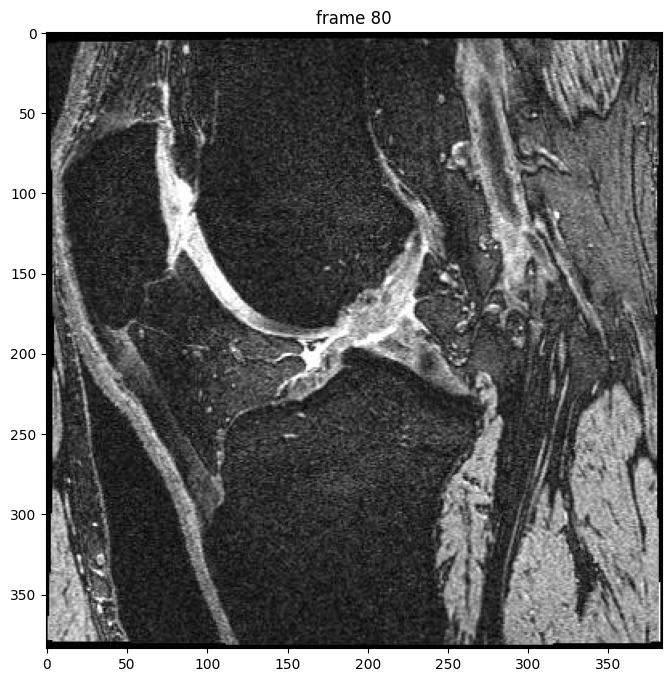

In [5]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "/home/asy51/vstor/data/oai/image03/00m/0.E.1/9223789/20050623/10929709_jpg"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 80
plt.figure(figsize=(12, 8))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])).convert('L'), cmap='gray')

In [6]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG):  22%|██▏       | 35/160 [00:00<00:02, 43.37it/s]

frame loading (JPEG): 100%|██████████| 160/160 [00:03<00:00, 42.56it/s]


In [7]:
predictor.reset_state(inference_state)

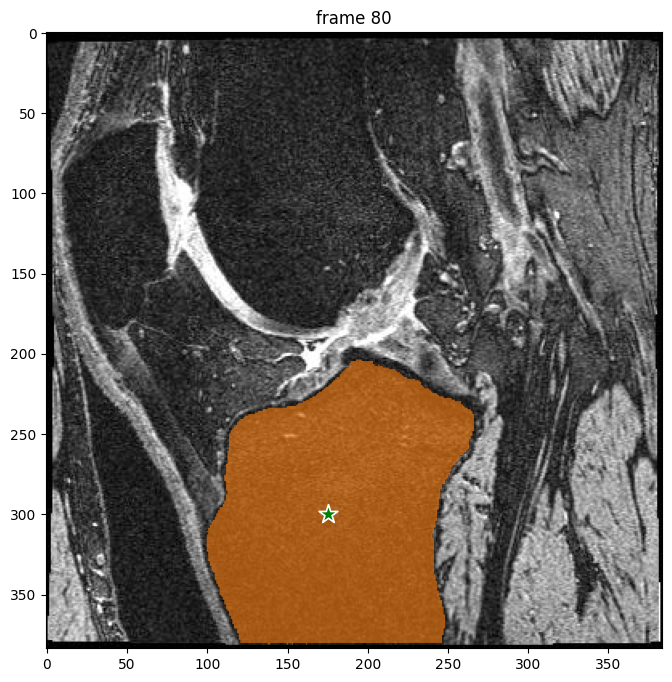

In [8]:
ann_frame_idx = 80  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[175, 300]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(12, 8))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])), cmap='gray')
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

In [10]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state, start_frame_idx=ann_frame_idx):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state, start_frame_idx=ann_frame_idx, reverse=True):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

propagate in video: 100%|██████████| 81/81 [00:03<00:00, 23.95it/s]


In [17]:
pred = np.concat([video_segments[idx][1] for idx in range(160)])

In [54]:
FRAME_NDX = 80
FEMUR_ID = 1
TIBIA_ID = 2
FEMUR_LOC = [175, 100]
TIBIA_LOC = [200, 300]

video_dirs = glob.glob('/home/asy51/vstor/data/oai/image03/00m/*/*/*/*_jpg')
for video_dir in video_dirs:
    frames = sorted(glob.glob(f'{video_dir}/*'))
    inference_state = predictor.init_state(video_path=video_dir)
    predictor.reset_state(inference_state)
    prompts = {}
    points = np.array([FEMUR_LOC], dtype=np.float32)
    labels = np.array([1], dtype=np.int32)
    prompts[FEMUR_ID] = points, labels
    _, out_obj_ids, out_mask_logits = predictor.add_new_points(
        inference_state=inference_state,
        frame_idx=FRAME_NDX,
        obj_id=FEMUR_ID,
        points=points,
        labels=labels,
    )
    points = np.array([TIBIA_LOC], dtype=np.float32)
    labels = np.array([1], dtype=np.int32)
    prompts[TIBIA_ID] = points, labels
    _, out_obj_ids, out_mask_logits = predictor.add_new_points(
        inference_state=inference_state,
        frame_idx=FRAME_NDX,
        obj_id=TIBIA_ID,
        points=points,
        labels=labels,
    )

    # plt.figure(figsize=(12, 8))
    # plt.title(f"frame {FRAME_NDX}")
    # plt.imshow(Image.open(frames[FRAME_NDX]), cmap='gray')
    # show_points(points, labels, plt.gca())
    # for i, out_obj_id in enumerate(out_obj_ids):
    #     show_points(*prompts[out_obj_id], plt.gca())
    #     show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

    video_segments = {}  # video_segments contains the per-frame segmentation results
    for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state, start_frame_idx=FRAME_NDX, reverse=False):
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
        }
    for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state, start_frame_idx=FRAME_NDX, reverse=True):
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
        }
    # pred = np.concat([video_segments[idx][1] for idx in range(len(frames))])
    # y = None
    # dice_fn = lambda _: 1.0
    # dice = dice_fn(pred, y)
    break

propagate in video: 100%|██████████| 81/81 [00:16<00:00,  5.00it/s]


In [58]:
pred_femur = np.concat([video_segments[i][FEMUR_ID] for i in range(len(video_segments))])
pred_tibia = np.concat([video_segments[i][TIBIA_ID] for i in range(len(video_segments))])

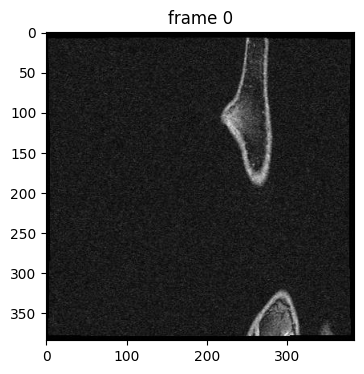

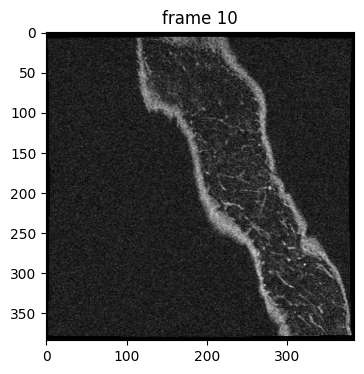

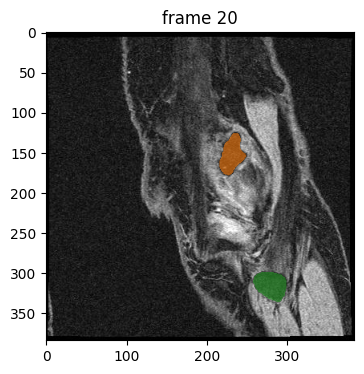

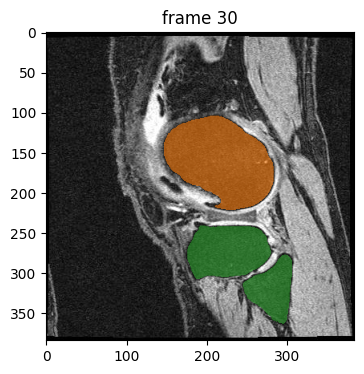

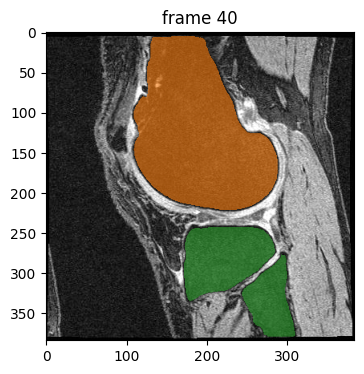

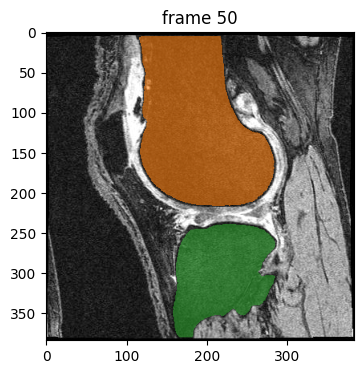

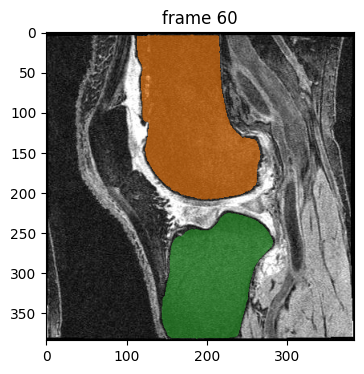

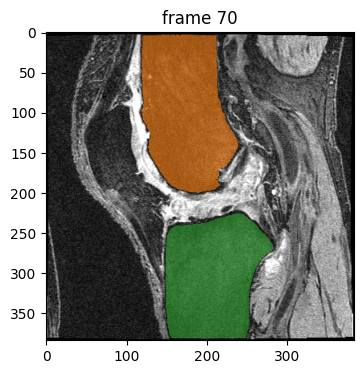

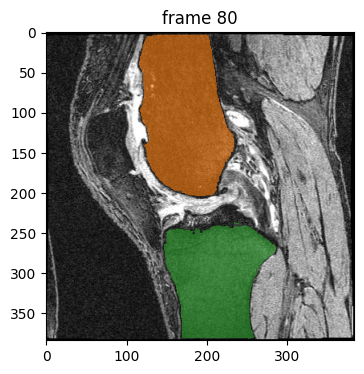

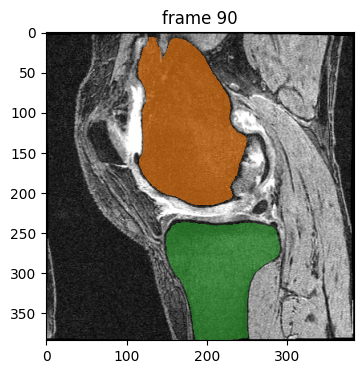

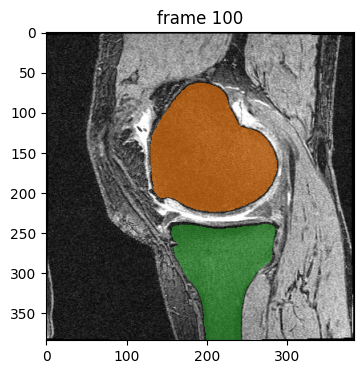

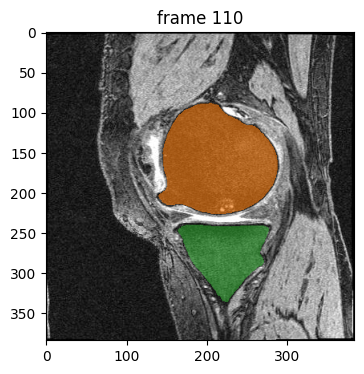

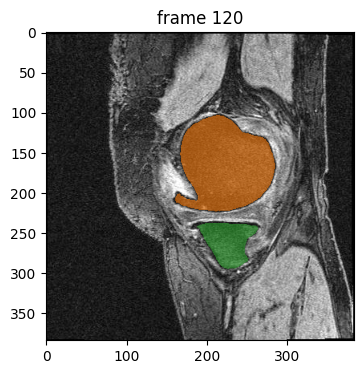

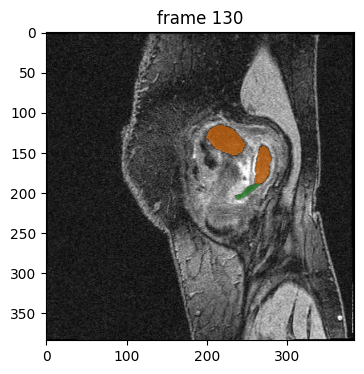

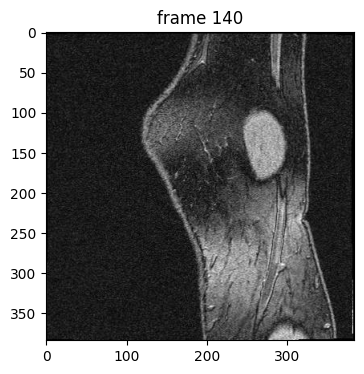

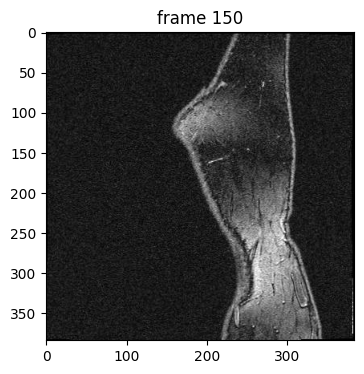

In [62]:
vis_frame_stride = 10
plt.close("all")
for out_frame_idx in range(0, len(frames), vis_frame_stride):
    plt.figure(figsize=(4, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frames[out_frame_idx])), cmap='gray')
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)